# Dia 3: Previsão de tendências e cenários futuros da CEAPS para o 1Q de 2023

A previsão de gastos parlamentares é uma ferramenta essencial para o planejamento orçamentário e a gestão eficiente dos recursos públicos. No terceiro dia de análise da CEAPS, exploramos métodos de forecasting para antecipar tendências e projetar cenários futuros dos reembolsos parlamentares.  

Utilizando técnicas de séries temporais e modelos estatísticos, buscamos identificar padrões históricos e prever os gastos dos senadores no primeiro trimestre de 2023. Para isso, empregamos três abordagens principais:  

- Baseline (média móvel): Uma estimativa simples baseada na média dos gastos dos últimos meses.  
- Prophet: Um modelo desenvolvido pelo Meta, eficiente na detecção de sazonalidade e tendências em séries temporais.  
- Regressão Linear: Um modelo estatístico que projeta os gastos futuros com base na relação entre tempo e valores históricos.  

Cada um desses modelos foi avaliado com métricas de erro para determinar sua precisão e eficácia na previsão dos reembolsos parlamentares. Os resultados obtidos fornecem insights importantes para o acompanhamento das despesas e auxiliam na tomada de decisões estratégicas no Senado Federal.  

# Importações

## 0.1 Bibliotecas e módulos

In [51]:
# Importa bibliotecas e módulos essenciais para análise, visualização e predição de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## 0.2 Carregamento dos dados limpos

In [52]:
# Carrega os dados limpos do arquivo pickle gerado pelo 01_data_cleaning.ipynb
df_ceaps_forecasting = pd.read_pickle('/Users/liviagrigolon/Documents/GitHub/7-days-of-data-science/data/processed/despesa_ceaps_2018_2022_limpo.pkl')

# 1 Preparação dos dados para Forecasting

Antes de criar o modelo de previsão, é essencial garantir que os dados estejam limpos e estruturados corretamente. Para utilizar modelos de **forecasting** em séries temporais, como o Facebook Prophet, é necessário que o dataset siga um formato específico.  

O modelo **Prophet** exige um arquivo contendo duas colunas principais:  
- **`ds` (Datetime Series):** representa as datas dos eventos. No nosso caso, corresponde ao dia de cada reembolso.  
- **`y` (Target Variable):** representa o valor numérico que queremos prever. Aqui, é a soma dos reembolsos dos senadores naquele dia.  

Com esse formato, o modelo poderá aprender os padrões de gastos e gerar previsões para os meses seguintes. Agora que os dados estão preparados, podemos seguir para a criação do modelo de previsão.


In [53]:
# Garantir que a coluna DATA esteja no formato datetime
df_ceaps_forecasting["DATA"] = pd.to_datetime(df_ceaps_forecasting["DATA"], errors="coerce")

# Remover linhas com datas inválidas
df_ceaps_forecasting = df_ceaps_forecasting.dropna(subset=["DATA"])

# Filtrar apenas os anos esperados (2018-2022) para evitar datas corrompidas
df_ceaps_forecasting = df_ceaps_forecasting[(df_ceaps_forecasting["DATA"].dt.year >= 2018) & (df_ceaps_forecasting["DATA"].dt.year <= 2022)]

# Agrupar por dia e somar os reembolsos
df_forecasting = df_ceaps_forecasting.groupby("DATA", as_index=False)["VALOR_REEMBOLSADO"].sum()

# Renomear colunas para o formato esperado pelo Prophet
df_forecasting = df_forecasting.rename(columns={"DATA": "ds", "VALOR_REEMBOLSADO": "y"})
# 
# Ordenar as datas para garantir que fiquem na sequência correta
df_forecasting = df_forecasting.sort_values(by="ds")

# Salvar o dataset em um arquivo CSV
df_forecasting.to_csv("data/processed/dataset_ceaps_forecasting.csv", index=False)

# Exibir as primeiras linhas para verificação
print(df_forecasting.head())


          ds         y
0 2018-01-01   8937.24
1 2018-01-02  27614.99
2 2018-01-03  32480.46
3 2018-01-04  16775.57
4 2018-01-05  31973.32


# 2 Modelos de previsão para gastos parlamentares

### 2.1 Baseline (média móvel)

No contexto de forecasting, um baseline comum é simplesmente assumir que o valor futuro será a média dos últimos meses. Nesse caso, a baseline simplesmente calculou a média dos gastos dos senadores nos últimos três meses e usou esse valor como previsão para os próximos três meses.

In [54]:
# Criar a baseline: prever com a média dos últimos 3 meses
df_forecasting["ds"] = pd.to_datetime(df_forecasting["ds"])  # Garantir que a coluna de datas está correta
df_forecasting = df_forecasting.set_index("ds").resample("ME").sum()  # Agregar por mês

# Últimos 3 meses para a baseline
last_3_months_avg = df_forecasting["y"].iloc[-3:].mean()

# Criar previsão baseline para os próximos 3 meses
baseline_forecast = pd.DataFrame({
    "ds": pd.date_range(start=df_forecasting.index[-1] + pd.DateOffset(months=1), periods=3, freq="ME"),
    "yhat": last_3_months_avg
})

### 2.2 Prophet

O Facebook Prophet é uma biblioteca desenvolvida pelo Meta para previsão de séries temporais. Ele é especialmente útil para modelar dados com sazonalidade e tendências, sendo amplamente utilizado em análises financeiras e de negócios.

Nesse caso, o Prophet analisará os gastos dos senadores ao longo do tempo, identificando padrões e variações sazonais. Com base nisso, ele criará uma projeção para os próximos três meses.

In [55]:
# Criar modelo Prophet
df_prophet = df_forecasting.reset_index()
model = Prophet()
model.fit(df_prophet)

# Criar datas futuras para previsão (3 meses)
future = model.make_future_dataframe(periods=3, freq="M")
forecast_prophet = model.predict(future)

19:51:46 - cmdstanpy - INFO - Chain [1] start processing


19:51:46 - cmdstanpy - INFO - Chain [1] done processing
/Users/liviagrigolon/Documents/GitHub/7-days-of-data-science/venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


### 2.3 Regressão Linear

A Regressão Linear é um modelo estatístico que busca identificar a relação entre uma variável independente (tempo) e uma variável dependente (gastos). Ele ajusta uma reta aos dados históricos e usa essa relação para prever valores futuros.

Aqui, utilizaremos a Regressão Linear para analisar a evolução dos gastos dos senadores e projetar os valores para os próximos três meses. Esse modelo é útil para identificar tendências lineares nos dados e comparar seu desempenho com outras abordagens, como o Prophet.

In [56]:
# Criar modelo de Regressão Linear
df_forecasting["month"] = np.arange(len(df_forecasting))  # Criar variável numérica para o tempo
X_train, y_train = df_forecasting[["month"]], df_forecasting["y"]

# Treinar o modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Criar previsões
future_months = np.arange(len(df_forecasting), len(df_forecasting) + 3).reshape(-1, 1)
lin_reg_pred = lin_reg.predict(future_months)

# Criar DataFrame com previsão da regressão
forecast_lr = pd.DataFrame({
    "ds": pd.date_range(start=df_forecasting.index[-1] + pd.DateOffset(months=1), periods=3, freq="M"),
    "yhat": lin_reg_pred
})

/Users/liviagrigolon/Documents/GitHub/7-days-of-data-science/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/tb/3rkysv496vs8fxvth4bytgs40000gn/T/ipykernel_98390/4002234790.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start=df_forecasting.index[-1] + pd.DateOffset(months=1), periods=3, freq="M"),


## 3 Avaliação dos modelos

Após a criação dos modelos de previsão (Baseline, Prophet e Regressão Linear), é necessário avaliar seu desempenho para verificar qual apresenta os melhores resultados.  

Para isso, utilizamos duas métricas comuns em problemas de forecasting:  
- **RMSE (Root Mean Squared Error)**: Mede o erro médio absoluto das previsões em relação aos valores reais. Quanto menor, melhor.  
- **MAPE (Mean Absolute Percentage Error)**: Mede o erro percentual médio das previsões. Também deve ser o menor possível.  

Além das métricas, vamos visualizar as previsões dos modelos em um gráfico comparando-as com os valores reais. Isso nos ajudará a entender se os modelos capturam bem a tendência dos dados.  

A seguir, aplicamos essas métricas aos três modelos e geramos a visualização das previsões.

Baseline (Média) - RMSE: 77174.88, MAPE: 6.90%
Prophet - RMSE: 254931.24, MAPE: 23.93%
Regressão Linear - RMSE: 93374.07, MAPE: 6.81%


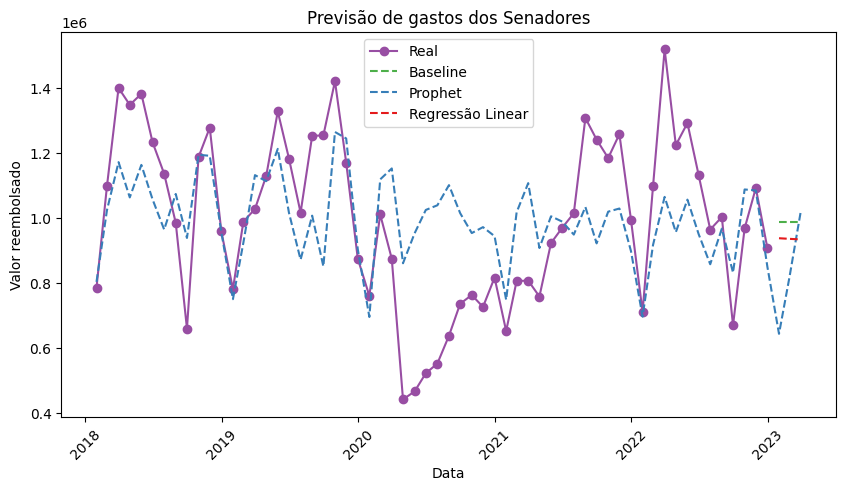

In [57]:
# Avaliação dos Modelos
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Comparação com os últimos 3 meses reais
y_real = df_forecasting["y"].iloc[-3:].values

evaluate_model(y_real, baseline_forecast["yhat"], "Baseline (Média)")
evaluate_model(y_real, forecast_prophet["yhat"].iloc[-3:], "Prophet")
evaluate_model(y_real, lin_reg_pred, "Regressão Linear")

# Definir paleta de cores prontas
colors = sns.color_palette("Set1", n_colors=4)

# Visualizar os resultados
plt.figure(figsize=(10, 5))
plt.plot(df_forecasting.index, df_forecasting["y"], label="Real", marker="o", color=colors[3])
plt.plot(baseline_forecast["ds"], baseline_forecast["yhat"], label="Baseline", linestyle="--", color=colors[2])
plt.plot(forecast_prophet["ds"], forecast_prophet["yhat"], label="Prophet", linestyle="--", color=colors[1])
plt.plot(forecast_lr["ds"], forecast_lr["yhat"], label="Regressão Linear", linestyle="--", color=colors[0])
plt.legend()
plt.xlabel("Data")
plt.ylabel("Valor reembolsado")
plt.title("Previsão de gastos dos Senadores")
plt.xticks(rotation=45)

plt.show()

## 4 Análise dos resultados

Após a avaliação dos modelos de previsão, obtivemos os seguintes resultados:  

- **Baseline (média)**
  - RMSE: 77.174,88  
  - MAPE: 6,90%  

- **Prophet**
  - RMSE: 254.931,24  
  - MAPE: 23,93%  

- **Regressão Linear**
  - RMSE: 93.374,07  
  - MAPE: 6,81%  

A baseline e a regressão linear tiveram desempenhos semelhantes, com RMSE e MAPE próximos, mas a regressão linear apresentou um erro ligeiramente menor, sugerindo que consegue capturar um pouco melhor a tendência dos dados. 

Já o modelo Prophet teve um desempenho inferior, com um erro absoluto maior e um MAPE de 23,93%, indicando dificuldades em modelar os padrões dos gastos, possivelmente devido à sazonalidade ou um ajuste inadequado dos hiperparâmetros.

## Conclusão

- Ao longo dos três dias de trabalho neste projeto, exploramos, limpamos e analisamos os dados de gastos parlamentares, buscando identificar padrões e tendências. 
- Implementamos diferentes abordagens para previsão, comparando a baseline, a regressão linear e o modelo Prophet. A avaliação final mostrou que a regressão linear e a baseline forneceram previsões mais confiáveis, enquanto o Prophet apresentou maior erro, sugerindo dificuldades em capturar a estrutura dos dados. 
- Esses resultados reforçam a importância de testar múltiplas abordagens antes de definir um modelo preditivo e evidenciam os desafios inerentes à modelagem de séries temporais com variações complexas.